In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
import fastsparsegams

In [94]:
#Returns X_aug, X_MVI, y
#no intercept because the model has an automatic intercept. 
def data_gen(n=10000, correlation_prop = 0.85, missingness_prop = 0.4, seed = None, n_vars = 3): 
    if n_vars < 2: 
        print('not enough variables!')
        return -1, -1, -1, -1
    
    if seed is not None: 
        np.random.seed(seed)
    
    X = np.random.choice([True, False], (n,n_vars+1))

    #with rate correlation_prop, X_:0 is equal to X_:1
    correlation_indices = np.random.permutation(n)[:int(correlation_prop*n)]
    X[correlation_indices, 0] = X[correlation_indices, 1]
    
    #Y is always X_:0
    y = np.copy(X[:, 0])
        
    #X_:0 is sometimes missing
    #missing_indices = np.random.permutation(n)[:int(missingness_prop*n)]

    # Get indices where X_0 * X_1 = 0
    mask_inds = X[:, 0] * X[:, 1] == 0
    potntial_missing_indices = np.argpartition(mask_inds, -int(missingness_prop*n))[-int(missingness_prop*n):]
    missing_indices = np.random.permutation(potntial_missing_indices)[:int(missingness_prop*n)]

    X[missing_indices, 0] = False
    #last column X_:-1 is missingness indicator for X_:0
    X[:, -1] = False
    X[missing_indices, -1] = True
    
    
    # create median/mode value imputation matrix (which does not include the missingness feature)
    imputed_mode = (X[:, 0]).sum() > (n * (1-missingness_prop))/2 #find majority vote of non-missing values for feature 0
    X_mvi = np.copy(X[:, :-1])
    X_mvi[missing_indices, 0] = imputed_mode
        
    #create augmented matrix (add interaction terms): 
    X_aug = np.concatenate([X, np.logical_and(X[:, -1].reshape(-1, 1), X[:, 1:-1])], axis=1)
    
    return X_aug, X_mvi, y

In [131]:
X_aug_train, X_mvi_train, y_train = data_gen(seed = 100, n_vars=10, correlation_prop=0.85, missingness_prop=0.2)

In [132]:
X_aug_test, X_mvi_test, y_test = data_gen(seed = 2, n_vars=10, correlation_prop=0.85, missingness_prop=0.2)

In [133]:
y_test.mean()

0.5025

In [134]:
model_augmented = fastsparsegams.fit(
    X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
)

In [135]:
trainacc_aug = []
coeff_aug = np.zeros((len(model_augmented.lambda_0[0]), X_aug_train.shape[1]))
testacc_aug = []
for i, lamby in enumerate(model_augmented.lambda_0[0]): 
    acc = ((model_augmented.predict(X_aug_train.astype(float),lambda_0=lamby)>0.5)==y_train.reshape(-1,1)).mean()
    trainacc_aug.append(acc)
    
    coeff_aug[i] = (model_augmented.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    
    acc_test = ((model_augmented.predict(X_aug_test.astype(float),lambda_0=lamby)>0.5)==y_test.reshape(-1,1)).mean()
    testacc_aug.append(acc_test)

Text(0, 0.5, 'Accuracy')

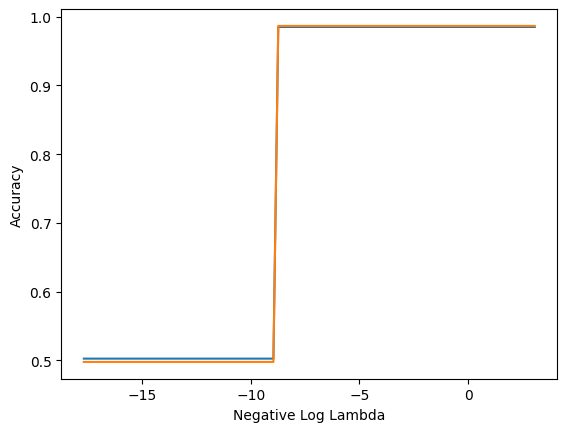

In [136]:
plt.plot(-np.log(model_augmented.lambda_0[0]), trainacc_aug)
plt.plot(-np.log(model_augmented.lambda_0[0]), testacc_aug)
plt.xlabel('Negative Log Lambda')
plt.ylabel('Accuracy')
# plt.plot(np.arange(0,100), trainacc_aug)
# plt.plot(np.arange(0,100), testacc_aug)
# plt.xlabel('Iteration (larger iteration -> smaller lambda)')
# plt.ylabel('Accuracy')

Text(0.5, 0, 'Negative Log Lambda')

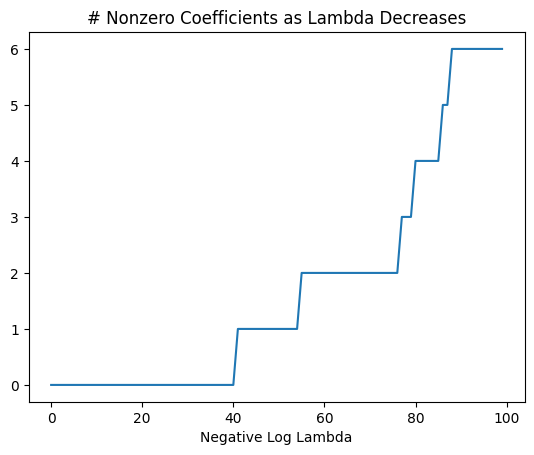

In [137]:
plt.title('# Nonzero Coefficients as Lambda Decreases')
# plt.plot(-np.log(model_augmented.lambda_0[0]), (coeff_aug > 0).sum(axis=1))
# plt.ylabel('# Nonzero coefficients')
# plt.xlabel('Negative Log Lambda')

plt.plot(np.arange(0,100), (abs(coeff_aug) > 0).sum(axis=1))
plt.xlabel('Iteration (larger iteration -> smaller lambda)')
plt.xlabel('Negative Log Lambda')

In [138]:
(model_augmented.coeff(lambda_0=model_augmented.lambda_0[0][70]).toarray().flatten())[:]

array([-9.2449376 , 18.21819238,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  7.98124099,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [139]:
coeff_aug[70]

array([18.21819238,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        7.98124099,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [140]:
coeff_aug[76]

array([18.23679575,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        7.99055075,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [141]:
trainacc_aug[80]

0.9852

In [142]:
testacc_aug[80]

0.9867

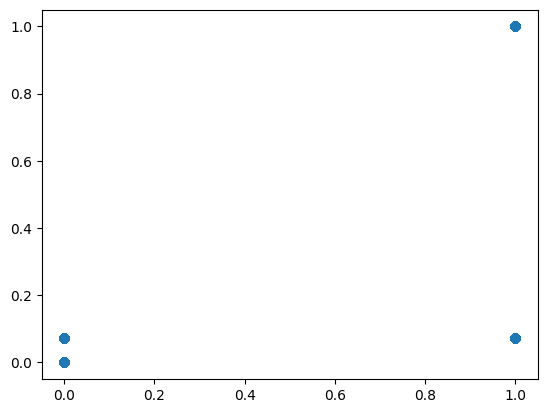

In [143]:
plt.scatter(y_train.astype(int), model_augmented.predict(X_aug_train.astype(float),lambda_0=model_augmented.lambda_0[0][60]))

### Notes from experiments: 

when the model uses just 1 coefficient, it uses just X_.1, as it should (no missingness, 85% correlation with y)
when it picks 2, it uses X_.0 and then accounts for missingness (use X_.0 as the perfect predictor it is when not missing, then use X_.1's interaction term with X_.0 missingness when X_:0 is missing).
when it picks 3, somehow the training and test accuracy remain unchanged???

coefficients printed are without the intercept term (which is normally the first coefficient)

for mvi (below) the model does the same when using just 1 coefficient, and uses X_.0 and X_.1 when using 2 coefficients, as it has to (those are the only two variables with signal). Grabs noise after that, and does not reach as high an objective

------------------

In [144]:
model_mvimented = fastsparsegams.fit(
    X_mvi_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
)
trainacc_mvi = []
coeff_mvi = np.zeros((len(model_mvimented.lambda_0[0]), X_mvi_train.shape[1]))
testacc_mvi = []
for i, lamby in enumerate(model_mvimented.lambda_0[0]): 
    acc = ((model_mvimented.predict(X_mvi_train.astype(float),lambda_0=lamby)>0.5)==y_train.reshape(-1,1)).mean()
    trainacc_mvi.append(acc)
    
    coeff_mvi[i] = (model_mvimented.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    
    acc_test = ((model_mvimented.predict(X_mvi_test.astype(float),lambda_0=lamby)>0.5)==y_test.reshape(-1,1)).mean()
    testacc_mvi.append(acc_test)

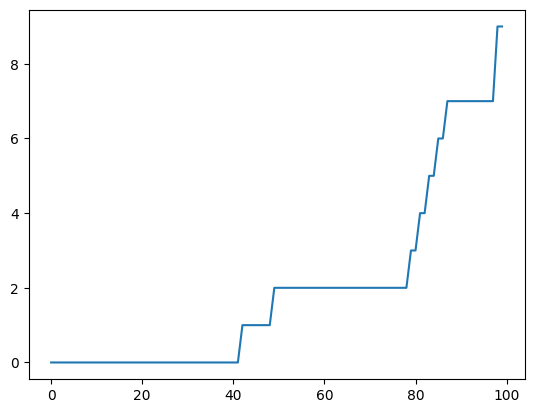

In [145]:
plt.plot(np.arange(100), (abs(coeff_mvi) > 0).sum(axis=1))

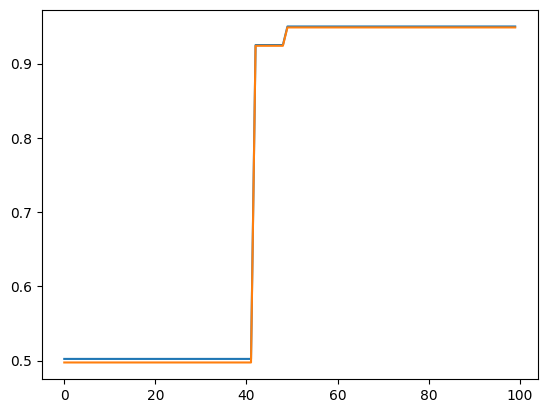

In [146]:
plt.plot(np.arange(100), trainacc_mvi)
plt.plot(np.arange(100), testacc_mvi)

In [147]:
coeff_mvi[50]

array([7.23537107, 2.52755707, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [148]:
testacc_mvi[99]

0.9487

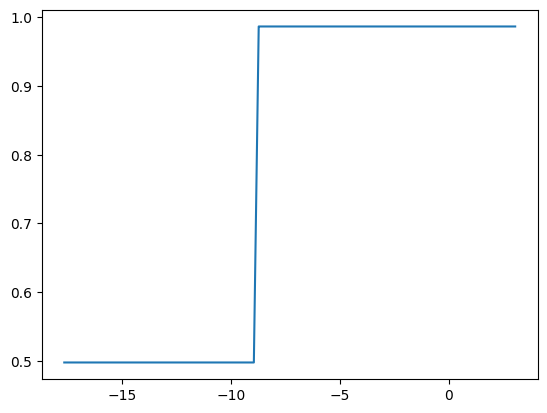

In [149]:
plt.plot(-np.log(model_augmented.lambda_0[0]), testacc_aug)

### Plot of basic accuracy/sparsity results

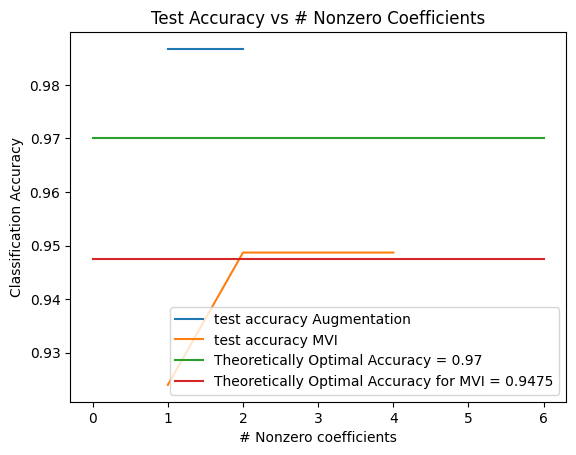

In [150]:
plt.title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept) , Non-intercept
# plt.plot((coeff_aug > 0).sum(axis=1), trainacc_aug, label='train accuracy Augmentation')
# plt.plot((coeff_mvi > 0).sum(axis=1), trainacc_mvi, label='train accuracy MVI')
plt.plot((coeff_aug > 0).sum(axis=1)[42:], testacc_aug[42:], label='test accuracy Augmentation')
plt.plot((coeff_mvi > 0).sum(axis=1)[42:], testacc_mvi[42:], label='test accuracy MVI')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.plot([0, 6], [0.97, 0.97], label='Theoretically Optimal Accuracy = 0.97')
plt.plot([0, 6], [0.9475, 0.9475], label='Theoretically Optimal Accuracy for MVI = 0.9475')
# plt.plot((coeff_mvi > 0).sum(axis=1), testacc_mvi, label='test accuracy MVI')

plt.legend()

# plt.plot(np.arange(0,100), (coeff_aug > 0).sum(axis=1))
# plt.xlabel('Iteration (larger iteration -> smaller lambda)')
# plt.xlabel('Negative Log Lambda')

# Calibration, Objective, etc

In [151]:
def get_true_probs(X_aug_test, X_mvi_test, y_test):
    true_probs_test = y_test.astype(float)
    true_probs_test[X_aug_test[:, 10] & X_aug_test[:, 1]] = y_test.astype(float)[X_aug_test[:, 1] & X_aug_test[:, 10]].mean()
    true_probs_test[X_aug_test[:, 10] & (~X_aug_test[:, 1])] = y_test.astype(float)[(~X_aug_test[:, 1]) & X_aug_test[:, 10]].mean()
    true_probs_test[(~X_aug_test[:, 10]) & X_aug_test[:, 1]] = y_test.astype(float)[X_aug_test[:, 1] & (~X_aug_test[:, 10])].mean()
    true_probs_test[(~X_aug_test[:, 10]) & (~X_aug_test[:, 1])] = y_test.astype(float)[(~X_aug_test[:, 1]) & (~X_aug_test[:, 10])].mean()
    return true_probs_test

In [152]:
true_probs_test = get_true_probs(X_aug_test, X_mvi_test, y_test)
true_probs_test = get_true_probs(X_aug_train, X_mvi_train, y_train)

(array([4975.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5025.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

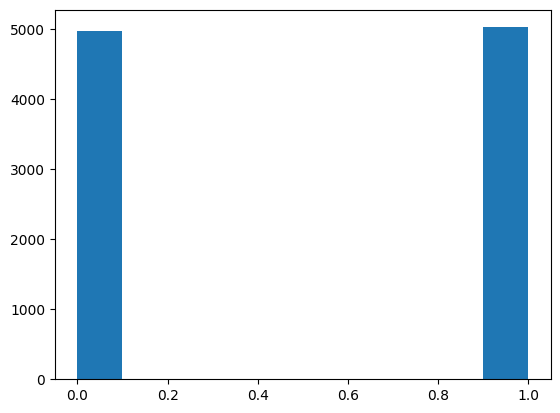

In [153]:

plt.hist(y_test.astype(float))

In [156]:
#true_probs_test[X_aug_test[:, 10]] = X_aug_test[:, 1][X_aug_test[:, 10]].astype(float) * 0.6 + 0.075

In [157]:
true_probs_test

array([0.   , 0.075, 0.   , ..., 0.   , 1.   , 0.075])

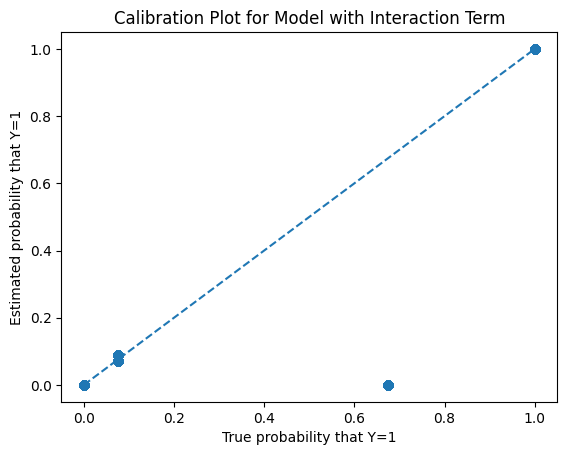

In [160]:
plt.scatter(true_probs_test, model_augmented.predict(X_aug_test.astype(float),lambda_0=model_augmented.lambda_0[0][80]))
plt.plot([0, 1], [0, 1], linestyle='dashed', label='line of perfect calibration')
plt.title('Calibration Plot for Model with Interaction Term')
plt.xlabel('True probability that Y=1')
plt.ylabel('Estimated probability that Y=1')
plt.savefig('calibration-ixn.png')

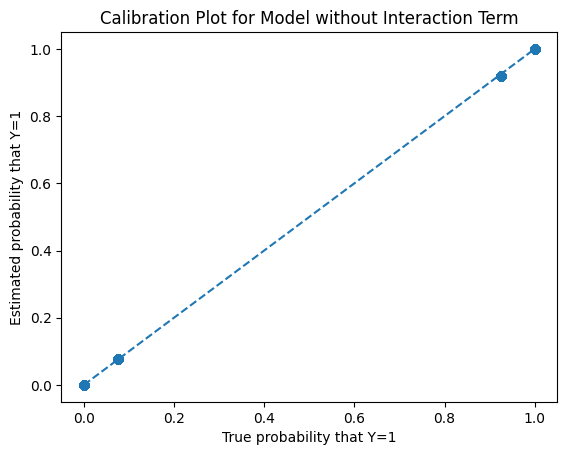

In [ ]:
plt.scatter(true_probs_test, model_augmented.predict(X_aug_test.astype(float),lambda_0=model_augmented.lambda_0[0][60]))
plt.plot([0, 1], [0, 1], linestyle='dashed', label='line of perfect calibration')
plt.title('Calibration Plot for Model without Interaction Term')
plt.xlabel('True probability that Y=1')
plt.ylabel('Estimated probability that Y=1')
plt.savefig('calibration-no-ixn.png')

In [100]:
print(model_augmented.coeff(lambda_0=model_augmented.lambda_0[0][60]).toarray().flatten())

[-8.70329833 14.52305883  2.46263892  0.          0.          0.
  0.          0.          0.          0.          0.          7.46452393
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


### Recover objective from prediction probability

In [108]:
def eval_score(probs, y):
    scores = 1/2 * np.log(probs/(1 - probs))
    return np.sum(np.exp(-1*y * scores.flatten()))

In [109]:
eval_score(model_augmented.predict(X_aug_test, lambda_0=model_augmented.lambda_0[0][50]), y_test)

6343.631870405837

In [110]:
eval_score(model_augmented.predict(X_aug_test, lambda_0=model_augmented.lambda_0[0][60]), y_test)

6032.553153310646